# Deep Learning - Multiple Hidden Layers

### This time we will develop a multi-layer fully connected neural network. 

### Two layer fully connected network consists of 
* Input layer
* Several hidden layers
* Output layer

### Again we will illistrate this classical method using the MNIST dataset. This could jest as easily be radiograph images although a great deal of data prepartation is done for us.


<BR>
<BR>
<img src="./images/mlp_mnist.png" width="600px"> 
    

# We will introduce a few new neural computaing concepts

## I. We will use a different activation function in our hidden layers. 

* The ReLU is a faster converging function which means it is more computationally efficient. 
* A drawback of the ReLU function is that it can lead to dead neurons if the learning rate is set too high.
* Although we will not explore it today, there is a derivative of the ReLU called the Leaky ReLU which helps to combat the vanishing gradient issue.

### <center> Rectified Linear Unit (ReLU) Activation Function </center>

<BR>
<img src="./images/ReLU.png" width="600px">



## II. We will introduce the concept of dropout in our input layers and hidden layers.

### The term “dropout” refers to dropping out units (both hidden and visible) in a neural network. Simply put, dropout refers to ignoring units (i.e. neurons) during the training phase chosen at random. By “ignoring”, this means these units are not considered during a particular forward or backward training pass.

### We perform dropout to prevent over-fitting our model. A fully connected layer occupies most of the parameters, and hence, neurons develop co-dependency amongst each other during training which curbs the individual power of each neuron leading to over-fitting of training data.

### So dropout is an approach to regularization in neural networks which helps reduce interdependent learning amongst the neurons.

<BR>
<img src="./images/dropout.png" width="500px">
<BR>
    
### Some observations of dropout

* Dropout forces a neural network to learn more robust features.
* Dropout roughly doubles the number of iterations required to converge. However, training time for each epoch is less.
* With <i><b>H</b></i> hidden units, each of which can be dropped, we have $2^H$ possible models. In testing phase, the entire network is considered and each activation is reduced by a factor p.

<BR>
<img src="./images/dropout-prob.png" width="500px">
<BR>
    
## III. We will introduce a new training optimization function.

### RMSPropOptimizer implements an adaptive version of Stochastic Gradient Descent based on the Root Mean Squared Propagation.


<BR>
<img src="./images/RMSProp.png" width="800px">
<BR>

# Let's look at our model

In [1]:
import numpy as np
import time
import tqdm
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# This convenience function will randomly initialize our weights  to values from a normal distribution 
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

In [3]:
# Combine the previous dataset with a new dataset of cases
def update_d(prev, new):
    combined = prev.copy()
    combined.update(new)
    return combined 

# We will define a fnction to train our model and display how it is doing
def train_model(sess, train_X, train_Y, test_X, test_Y, train_operation, accuracy_operation, num_epochs, batch_size, test_size, train_feed=dict(),test_feed=dict()):
    accuracies = []
    startingTime = time.time()
    with tqdm.tqdm(total = num_epochs * len(train_X)) as ranger:
        for epoch in range(num_epochs): # An epoch is a run through our entire training data set
            for start in range(0, len(train_X), batch_size): # loop in batches of batch size
                end = start + batch_size
                sess.run(train_operation, feed_dict=update_d(train_feed, {X: train_X[start:end],y: train_Y[start:end]}))
                ranger.update(batch_size)
                if (start // batch_size) % 100 == 0: # Let's record accuracy every batch
                    testSet = np.random.choice(len(test_X), test_size, replace=False)
                    tstX, tstY = test_X[testSet], test_Y[testSet]
                    accuracies.append(sess.run(accuracy_operation, feed_dict = update_d(test_feed, {X: tstX, y: tstY})))
                    ranger.set_description("Test Accuracy: " + str(accuracies[-1]))
            # print out the final test accuracy                                                       
            testSet = np.random.choice(len(test_X),test_size,replace=False)
            tstX, tstY = test_X[testSet], test_Y[testSet]
            accuracies.append(sess.run(accuracy_operation, feed_dict = update_d(test_feed, {X: tstX, y: tstY})))
            ranger.set_description("Test Accuracy: " + str(accuracies[-1]))
    timeTaken = time.time() - startingTime
    print("Finished training for %d epochs" % num_epochs)
    print("Took %.02f seconds (%.02f s per epoch)" % (timeTaken, timeTaken/num_epochs))
    accuracies.append(sess.run(accuracy_operation, feed_dict = update_d(test_feed, {X:test_X, y: test_Y})))
    print("Final accuracy was %.04f" % accuracies[-1])
    plt.plot(accuracies)


In [4]:
# A placeholder is not a value! We just need to define how we will hold onto our training cases. 
# "None" means that this dimension can be any length.

# X will be our input placeholder for a image case
X = tf.placeholder("float",shape=[None,784])
# Y will be a placeholder for our output distribution
y = tf.placeholder("float",shape=[None,10])

In [5]:
# We will define our weight variables coming in and out of the hidden layers and entering the output layer
# We take advantage of the convenience function init_weights to do this work.
NUM_HIDDEN = 620
W_h1 = init_weights([784,NUM_HIDDEN]) # Weights entering hidden layer 1
W_h2 = init_weights([NUM_HIDDEN,NUM_HIDDEN]) # Weights entering hidden layer 2
W_o = init_weights([NUM_HIDDEN,10]) # Weights entering the output layer
b_h1 = init_weights([1, NUM_HIDDEN]) # Let's define our bias weights for the hidden layer 1
b_h2 = init_weights([1, NUM_HIDDEN]) # Let's define our bias weights for the hidden layer 2
b_o = init_weights([1, 10]) # Let's define our bias weights for the output layer

In [6]:
# We now need some place holders for our dropout parameters
drop_rate_input = tf.placeholder("float")
drop_rate_hidden = tf.placeholder("float")

In [7]:
# Let's calculate our weights between the input layer and the hidden layer
# We will also add some dropout to our input layer and our first hidden layer
# We will also use the ReLU activation function for our hidden layers
out_X = tf.nn.dropout(X, drop_rate_input)
in_h1 = tf.matmul(out_X, W_h1) + b_h1
out_h1 = tf.nn.dropout(tf.nn.relu(in_h1), drop_rate_hidden)
in_h2 = tf.matmul(out_h1, W_h2) + b_h2
out_h2 = tf.nn.relu(in_h2)
y_hat = tf.matmul(out_h2, W_o) + b_o

In [8]:
# Now we can define our loss function. Cross entropy with logits and we average across our batch.
# We generate unnormalized log probabilities (aka logits) and we want the outputs normalized linear probabilities
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_hat))

In [9]:
# Define our new RMSProp optimizer
# Again, we want to minimize our loss function, that is cross entropy. 
# We will set a learning rate and a decay of the historical gradient. The smaller the decay factor,
# the shorter the effective window. 
train_operation = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cross_entropy)

# Let's define our prediction operation, that is the largest probability among our 10 possible output labels
predict_operation = tf.argmax(y_hat, 1)
# Let's define our accuracy operation
accuracy_operation = tf.reduce_mean(tf.cast(tf.equal(predict_operation,tf.argmax(y,1)),tf.float32))

In [10]:
# Let's read in our MNIST data
mnist = input_data.read_data_sets("data", one_hot=True)
trX, trY = mnist.train.images, mnist.train.labels
tstX, tstY = mnist.test.images, mnist.test.labels

Extracting data\train-images-idx3-ubyte.gz
Extracting data\train-labels-idx1-ubyte.gz
Extracting data\t10k-images-idx3-ubyte.gz
Extracting data\t10k-labels-idx1-ubyte.gz


Test Accuracy: 0.9805: 100%|███████████████████████████████████████████████| 2750000/2750000 [06:43<00:00, 6813.84it/s]


Finished training for 50 epochs
Took 403.59 seconds (8.07 s per epoch)
Final accuracy was 0.9805


(0.8, 1)

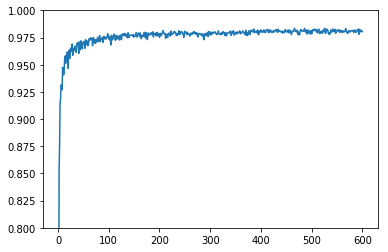

In [11]:
NUM_EPOCHS = 50 # Number of complte time through our traing data
BATCH_SIZE = 50 # Training batches
accuracies = []
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    train_model(sess, trX, trY, tstX, tstY, train_operation, accuracy_operation, NUM_EPOCHS, BATCH_SIZE, 10000,\
               {drop_rate_input:0.7,drop_rate_hidden: 0.4}, {drop_rate_hidden:1, drop_rate_input:1})
plt.ylim(.8,1)

#### What tuning parameters can we play with?